# silver price

## load tha data

In [821]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genextreme, genpareto
import scipy

# Load dataset
df = pd.read_csv('silver.csv')
df.head()

,Date,USD
0,2022-04-21,24.645
1,2022-04-20,25.200
2,2022-04-19,25.915
3,2022-04-14,25.655
4,2022-04-13,25.640


## Handle missing values

In [822]:
# Convert date column to datetime
df['Date'] = pd.to_datetime(df['Date'])
# Remove data before 2005
df = df[df['Date'] >= '2005-01-01']
# Handle missing values (forward-fill method)
df['USD'] = df['USD'].ffill()
# Compute rate changes (percentage change in Silver price)
df['rate_change'] = df['USD'].pct_change()
# Remove NaN from first difference
df = df.dropna()

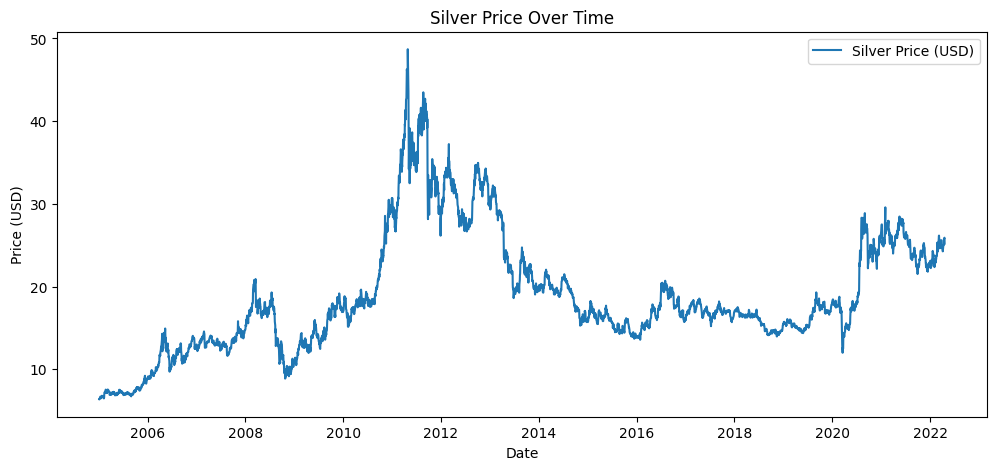

In [823]:
# Plot Silver Prices
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['USD'], label='Silver Price (USD)')
plt.title('Silver Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

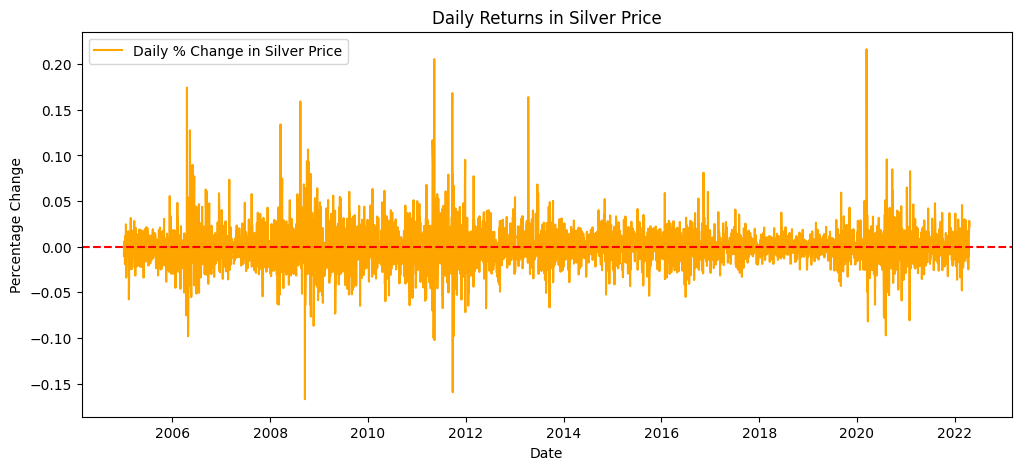

In [824]:
# Plot Silver Returns
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['rate_change'], label='Daily % Change in Silver Price', color='orange')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Daily Returns in Silver Price')
plt.xlabel('Date')
plt.ylabel('Percentage Change')
plt.legend()
plt.show()

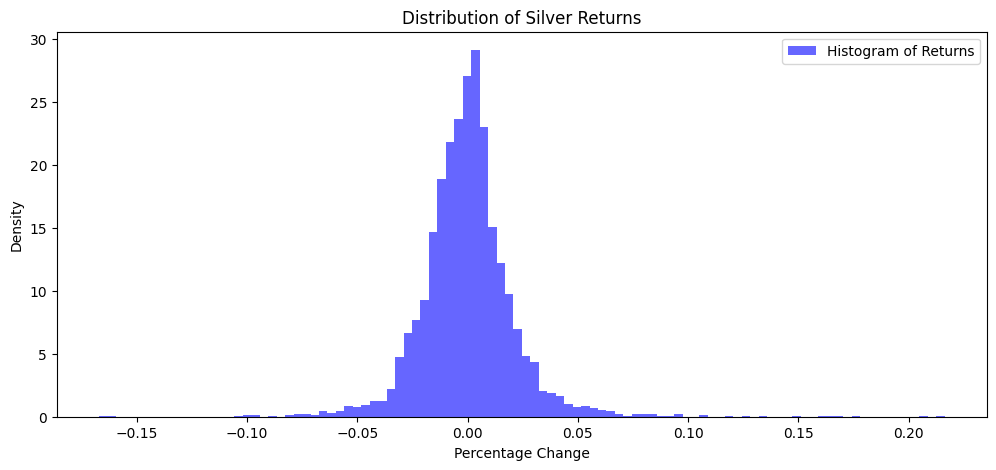

In [825]:
plt.figure(figsize=(12,5))
plt.hist(df['rate_change'], bins=100, density=True, alpha=0.6, color='b', label='Histogram of Returns')
plt.title('Distribution of Silver Returns')
plt.xlabel('Percentage Change')
plt.ylabel('Density')
plt.legend()
plt.show()

In [826]:
# Block Maxima Method for hikes (positive changes)
df['year_month'] = df['Date'].dt.to_period('2W')
block_maxima_hikes = df.groupby('year_month')['rate_change'].max()

# Block Minima Method for cuts (negative changes)
block_minima_cuts = df.groupby('year_month')['rate_change'].min()

GEV Parameters (Hikes - Shape, Location, Scale): (np.float64(-0.14190126922213953), np.float64(0.01268000621252256), np.float64(0.011873908580658725))
GEV Parameters (Cuts - Shape, Location, Scale): (np.float64(-0.03270728679846248), np.float64(0.01419546060379747), np.float64(0.011763549308170453))


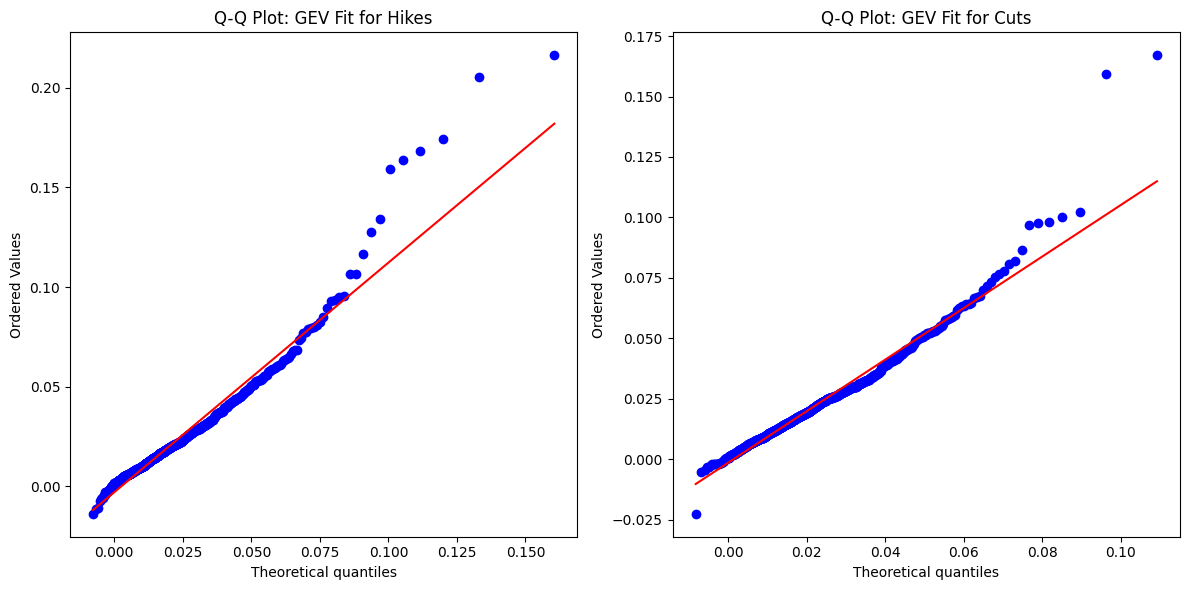

In [827]:
# Fit GEV Distribution for hikes
gev_params_hikes = genextreme.fit(block_maxima_hikes)
print("GEV Parameters (Hikes - Shape, Location, Scale):", gev_params_hikes)

# Fit GEV Distribution for cuts
gev_params_cuts = genextreme.fit(-block_minima_cuts)  # Negate values to fit correctly
print("GEV Parameters (Cuts - Shape, Location, Scale):", gev_params_cuts)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Q-Q Plot for Block Maxima Hikes
scipy.stats.probplot(block_maxima_hikes, dist=genextreme, sparams=gev_params_hikes, plot=axes[0])
axes[0].set_title("Q-Q Plot: GEV Fit for Hikes")

# Q-Q Plot for Block Minima Cuts
scipy.stats.probplot(-block_minima_cuts, dist=genextreme, sparams=gev_params_cuts, plot=axes[1])
axes[1].set_title("Q-Q Plot: GEV Fit for Cuts")

# Adjust layout
plt.tight_layout()
plt.show()

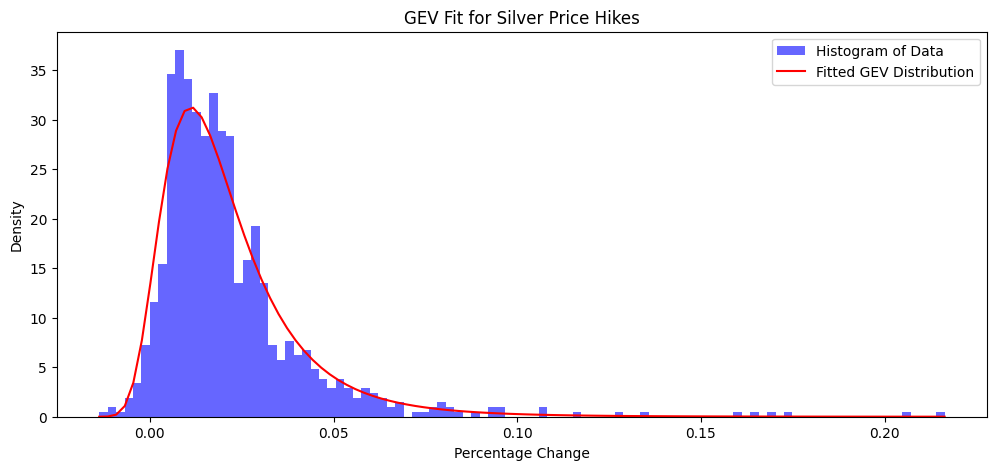

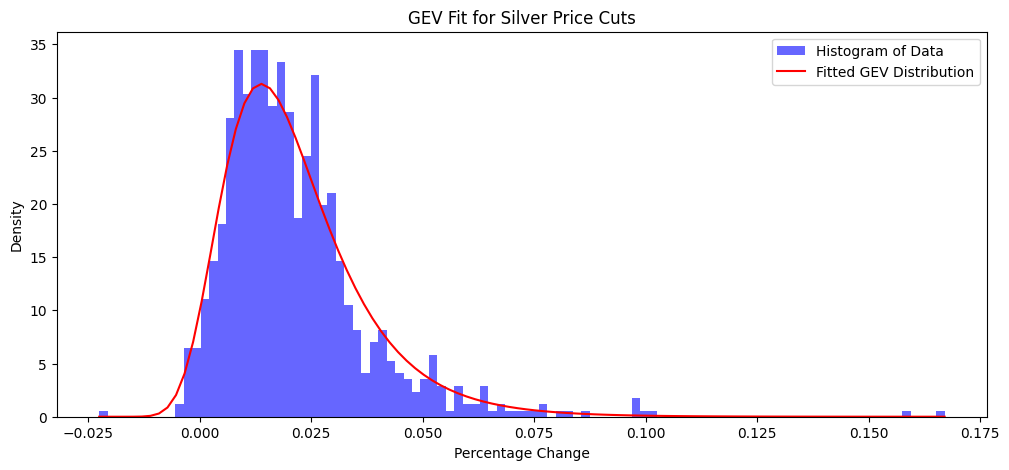

In [828]:
# Visualizing the Fitted GEV Distribution
def plot_gev_fits(data, gev_params, title):
    plt.figure(figsize=(12, 5))
    x = np.linspace(min(data), max(data), 100)
    pdf = genextreme.pdf(x, *gev_params)
    plt.hist(data, bins=100, density=True, alpha=0.6, color='b', label='Histogram of Data')
    plt.plot(x, pdf, 'r-', label='Fitted GEV Distribution')
    plt.title(title)
    plt.xlabel('Percentage Change')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

plot_gev_fits(block_maxima_hikes, gev_params_hikes, 'GEV Fit for Silver Price Hikes')
plot_gev_fits(-block_minima_cuts, gev_params_cuts, 'GEV Fit for Silver Price Cuts')

GPD Parameters (Hikes - Shape, Location, Scale): (np.float64(0.2601897123062551), np.float64(0.021373056751374384), np.float64(0.013052613891887558))
GPD Parameters (Cuts - Shape, Location, Scale): (np.float64(0.013370998882486163), np.float64(0.022921522845827727), np.float64(0.011523438574525676))


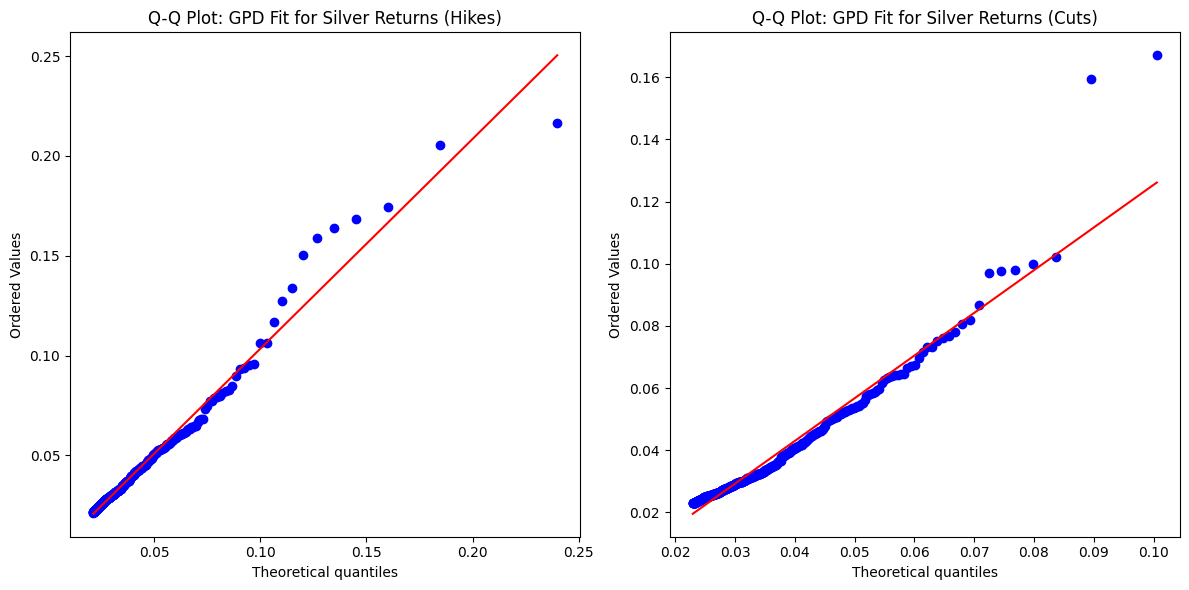

In [829]:
# Peak Over Threshold (POT) Method
threshold_pos = df['rate_change'].quantile(0.90)
extreme_hikes = df[df['rate_change'] > threshold_pos]['rate_change']
gpd_params_hikes = genpareto.fit(extreme_hikes)
print("GPD Parameters (Hikes - Shape, Location, Scale):", gpd_params_hikes)

threshold_neg = df['rate_change'].quantile(0.10)
extreme_cuts = df[df['rate_change'] < threshold_neg]['rate_change']
gpd_params_cuts = genpareto.fit(-extreme_cuts)
print("GPD Parameters (Cuts - Shape, Location, Scale):", gpd_params_cuts)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Q-Q Plot for GPD Fit (Extreme Hikes)
scipy.stats.probplot(extreme_hikes, dist=genpareto, sparams=gpd_params_hikes, plot=axes[0])
axes[0].set_title("Q-Q Plot: GPD Fit for Silver Returns (Hikes)")

# Q-Q Plot for GPD Fit (Extreme Cuts)
scipy.stats.probplot(-extreme_cuts, dist=genpareto, sparams=gpd_params_cuts, plot=axes[1])
axes[1].set_title("Q-Q Plot: GPD Fit for Silver Returns (Cuts)")

# Adjust layout
plt.tight_layout()
plt.show()

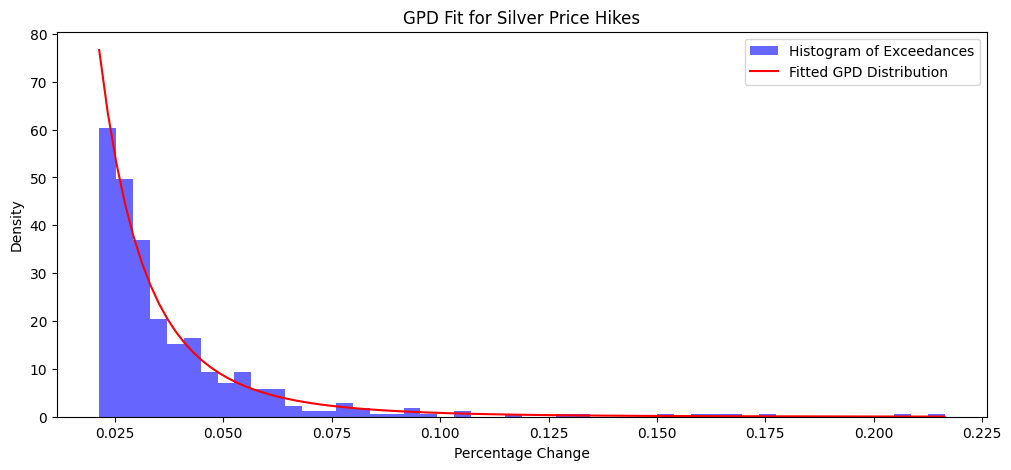

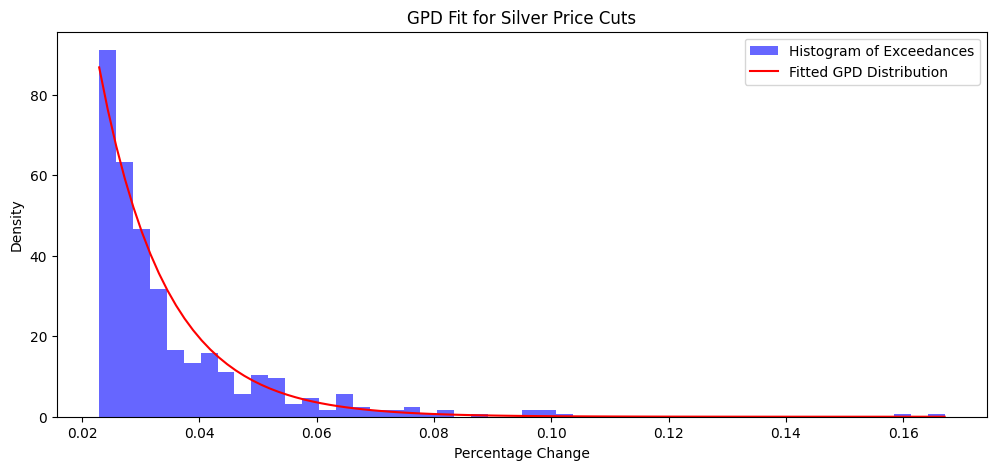

In [830]:
# Visualizing the Fitted GPD Distribution
def plot_gpd_fits(data, gpd_params, title):
    plt.figure(figsize=(12, 5))
    x = np.linspace(min(data), max(data), 100)
    pdf = genpareto.pdf(x, *gpd_params)
    plt.hist(data, bins=50, density=True, alpha=0.6, color='b', label='Histogram of Exceedances')
    plt.plot(x, pdf, 'r-', label='Fitted GPD Distribution')
    plt.title(title)
    plt.xlabel('Percentage Change')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

plot_gpd_fits(extreme_hikes, gpd_params_hikes, 'GPD Fit for Silver Price Hikes')
plot_gpd_fits(-extreme_cuts, gpd_params_cuts, 'GPD Fit for Silver Price Cuts')